In [1]:
from corner import corner
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14)
import pickle
from sbi.inference import SNPE,SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
# import ultranest
from sbi.inference import SNPE_C
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 403)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

net = Net()
#print(net)

class SummaryNet(nn.Module): 

    def __init__(self): 
        super().__init__()
        self.fc1 = nn.Linear(403, 32)
#        self.fc2 = nn.Linear(256, 128)
#        self.fc3 = nn.Linear(128, 64)

    def forward(self, x):
#        x = F.relu(self.fc1(x))
#        x = F.relu(self.fc2(x))
        x = self.fc1(x)
        return x

embedding_net = SummaryNet()

# args = parse_args()

# if args.embedding:
#         print('Embedding net')
# print(args.hidden, args.transforms, args.bins, args.blocks)

device = 'cpu'

xscaler = pickle.load(open('xscaler.p', 'rb'))
yscaler = pickle.load(open('yscaler.p', 'rb'))
noise   = np.loadtxt('noise.dat')

prior_min = torch.tensor(yscaler.transform([[100., 0.1,-3,-8,-3,0.1,2.3]]).reshape(-1))
prior_max = torch.tensor(yscaler.transform([[5000.,2, 3, 2, 3, 1.9, 4.3]]).reshape(-1))

prior = utils.BoxUniform(low=prior_min.to(device, non_blocking=True), high=prior_max.to(device, non_blocking=True), device=device)

## Define simulator

def arcis_sim(params):
    net = torch.load('arcis_emulator.pt',map_location=torch.device(device))
    params=(params.clone().detach().reshape(1,-1))
    out = net.float()(torch.tensor(params, device=device))
    out = out.cpu().clone().detach().numpy()
    # noisy = np.repeat(clean, ncopies, axis=0) + 1e2*noise*np.random.randn(ncopies,len(clean))
    # return torch.tensor(clean, device=device)
    return xscaler.inverse_transform(out)


#### CREATE OBSERVATION ####

inputs= np.array([[3205., 1.42, 2.59, -6.4, 0.63, 1.367, 2.94]], dtype=float)
input_ = yscaler.transform(inputs)
input_torch = torch.tensor(input_)
spec = arcis_sim(input_torch.clone().detach().float())

x_o = torch.tensor(spec, device=device)

FileNotFoundError: [Errno 2] No such file or directory: 'xscaler.p'

In [4]:
prior_bounds = np.loadtxt('prior.dat')

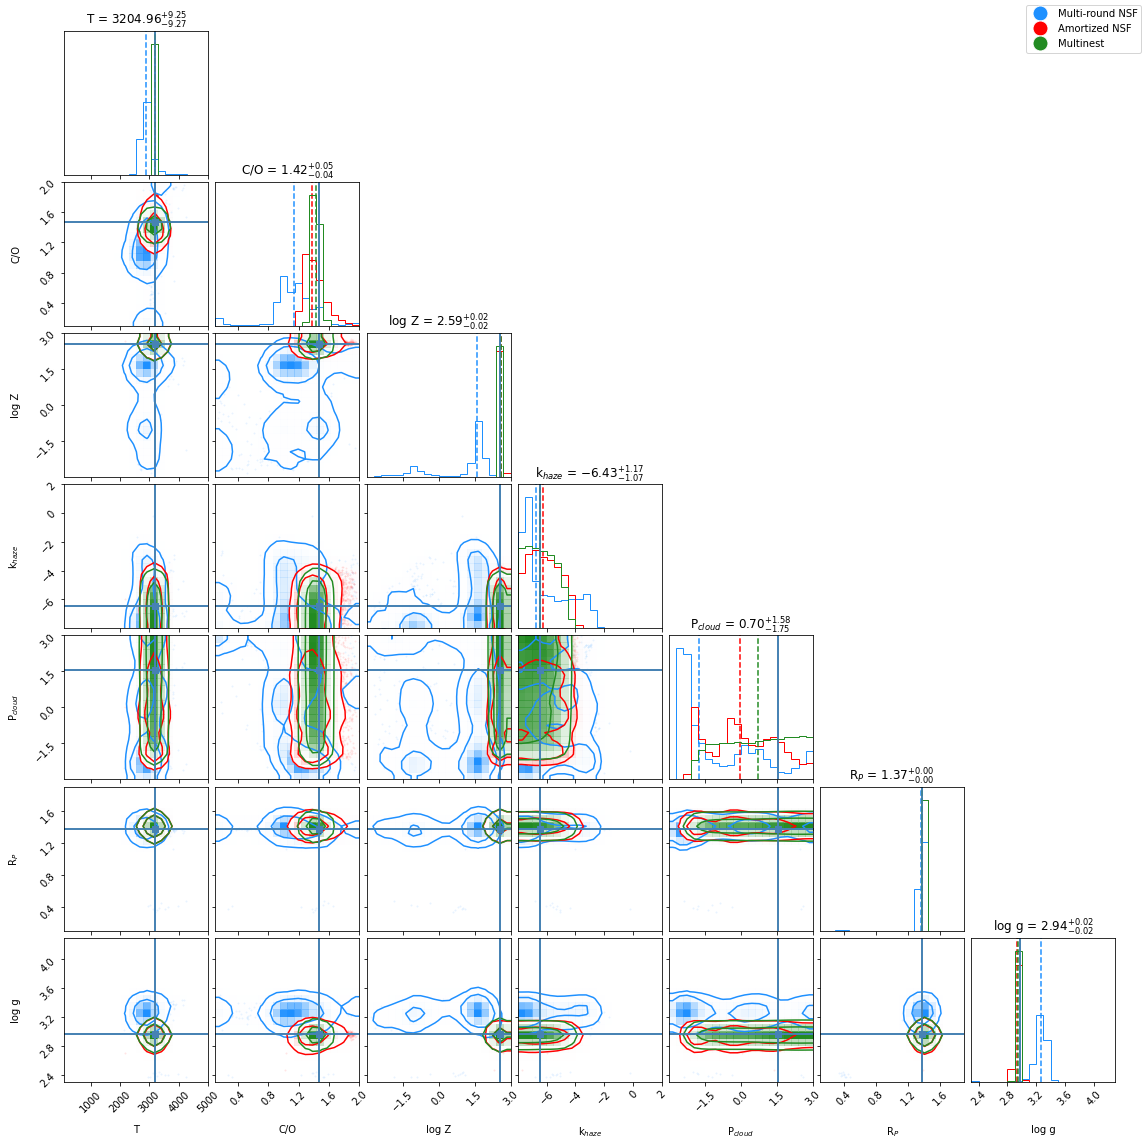

In [6]:
LOWER_ = np.array([100, 0.1, -3, -8, -3, 0.1, 2.3])
UPPER_ = np.array([5000, 2, 3, 2, 3, 1.9, 4.3])

names=[r'$T$', r'$C/O$', r'$\log Z$', r'$\log \kappa_{haze}$', r'$\log P_{cloud}$', r'$R_P$', r'$\log g$']

CORNER_KWARGS = dict(
    smooth = .9,
    levels = [0.68, 0.95],
    quantiles = [0.5],
    show_titles = True,
    # plot_contours=False,
    # fill_contours=False,
    # plot_density=False,
    labels = ['T', 'C/O', 'log Z',  r'k$_{haze}$', r'P$_{cloud}$', r'R$_P$', 'log g'],
    # range = [(100, 5000), (0.1, 2), (-3, 3), (-8, 2), (-3, 3), (0.1, 1.9), (2.3, 4.3)],
    range = prior_bounds,
    truths = np.loadtxt('../obs_w_noise/parameters')[29]
)

post1 = np.loadtxt('../MulteXBI_output/10x2500/round_20_samples.dat')
# post1 = pickle.load(open('../MulteXBI_output/10x2500/round_20_samples.dat', 'rb'))[3]
post2 = np.loadtxt('../post_29_nsf.txt')
post3 = np.loadtxt('../nirspec_29_post.dat')[:,:-1]

fig1 = corner(post1, color = 'dodgerblue', **CORNER_KWARGS)

weights = np.ones(len(post2))*len(post1)/len(post2)

fig2 = corner(post2, color = 'red', weights=weights, fig=fig1, **CORNER_KWARGS)

weights = np.ones(len(post3))*len(post1)/len(post3)

fig2 = corner(post3, color = 'forestgreen', weights=weights, fig=fig1, **CORNER_KWARGS)
    

from matplotlib.lines import Line2D
custom_lines = [
                Line2D([0], [0], marker='o', markersize=15, color='w', markerfacecolor='dodgerblue'),
                # Line2D([0], [0], marker='o', markersize=15, color='w', markerfacecolor='mediumblue'),
                Line2D([0], [0], marker='o', markersize=15, color='w', markerfacecolor='red'),
                Line2D([0], [0], marker='o', markersize=15, color='w', markerfacecolor='forestgreen'),
                # Line2D([0], [0], marker='o', markersize=15, color='w', markerfacecolor='mediumblue')
               ]

fig1.legend(custom_lines, [
                            'Multi-round NSF', 
                           'Amortized NSF', 
                           'Multinest',
                            # 'Combining+Discarding',
                            # '1x100k',
                           # '5x2k (5)'
            ])

# for i in range(5):
#     fig1 = corner(yscaler.inverse_transform(samples_5x10[i]), color = 'hotpink', **CORNER_KWARGS)
    
#     fig1.suptitle('Round '+ str(i))
    
#     plt.savefig('corner_5x10k_'+str(i)+'.pdf', bbox_inches='tight')

PLot best fit and stuff

In [23]:
x_o = np.loadtxt('../obs_w_noise/29')

In [55]:
X = np.zeros([1000,x_o.shape[0]])

dirx = '5x5k_com_dis_nat/' + 'round_'+str(1)+'_out/'

print('Reading ARCiS output')

from tqdm import trange

for i in trange(1000):
    if i+1<10:
        model_dir = dirx + 'model00000'+str(i+1)
    elif i+1<100:
        model_dir = dirx + 'model0000'+str(i+1)
    elif i+1<1000:
        model_dir = dirx + 'model000'+str(i+1)
    elif i+1<1e4:
        model_dir = dirx + 'model00'+str(i+1)
#     print(model_dir)
    try:
        X[i] = np.loadtxt(model_dir+'/trans')[:,1]# + x_o[:,2]*np.random.randn(1, x_o.shape[0])
    except:
        print(model_dir)

Reading ARCiS output


100%|█████████████████████████████████████████| 1000/1000 [00:02<00:00, 442.86it/s]


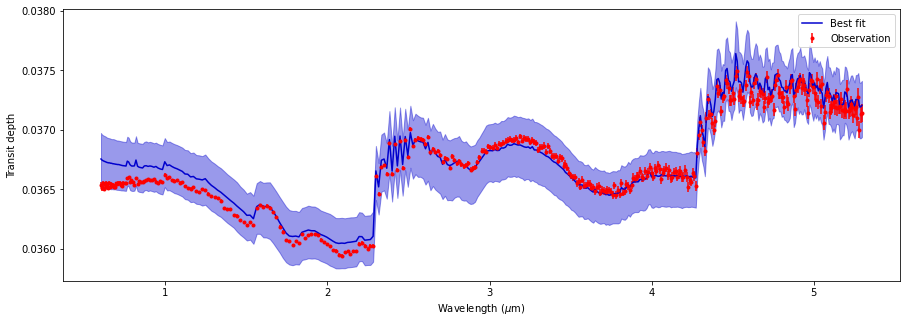

In [56]:
plt.figure(figsize=(15,5))
plt.errorbar(x = x_o[:,0], y=x_o[:,1], yerr=x_o[:,2], color='red', ls='', fmt='.', label='Observation')
# for i in range(1000):
    # plt.plot(x_o[:,0], X[i], c='blue', alpha=0.15)
plt.plot(x_o[:,0], np.median(X, axis=0), c='mediumblue', label='Best fit')
plt.fill_between(x_o[:,0], np.percentile(X, 84, axis=0), np.percentile(X, 16, axis=0), color='mediumblue', alpha=0.4)
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Transit depth')
plt.legend()